In [1]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt

from bmadx.beam_generator import create_beam

from phase_space_reconstruction.virtual.beamlines import quad_drift
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.visualization import plot_scan_data, plot_predicted_screens

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# create synthetic ground truth beam from base and transform yaml files
gt_beam = create_beam(
    base_yaml = os.path.join('base.yaml'),
    transforms_yaml = os.path.join('transforms.yaml'),
    p0c = 10.0e6,
    save_as = os.path.join('gt_beam.pt'),
    n_particle=10000
)

# swap y-xp distributions
data = gt_beam.data.clone()
data = torch.index_select(data, -1, torch.tensor([0,2,1,3,4,5]))
gt_beam.data = data

ground truth distribution saved at gt_beam.pt


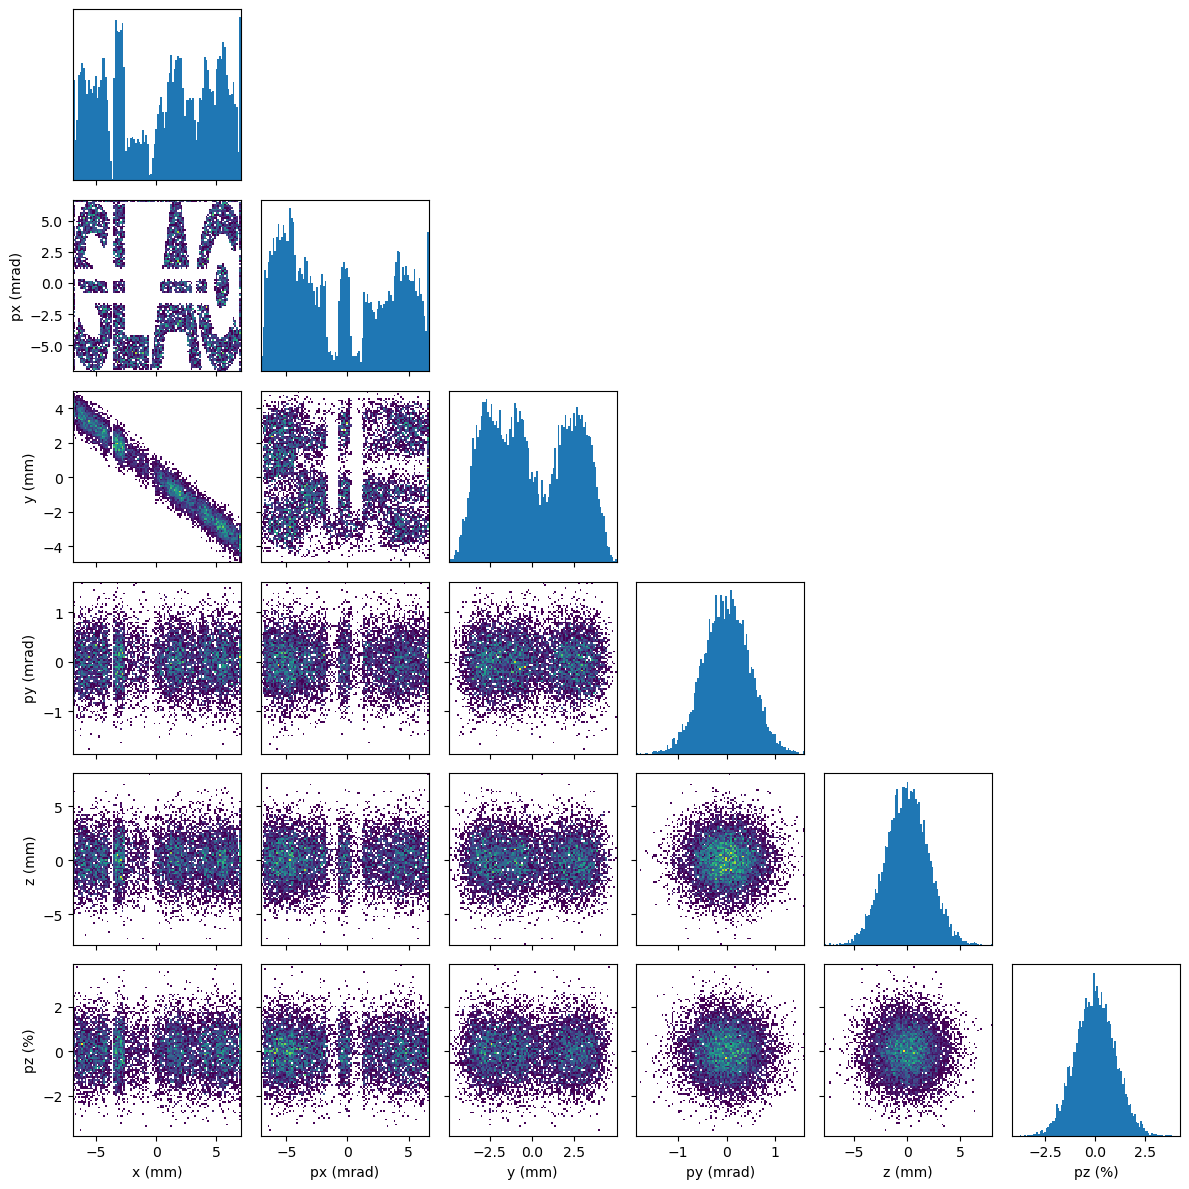

In [3]:
# plot synthetic ground truth beam projections
fig, ax = plot_projections(gt_beam.numpy_particles(), bins=100)
plt.show()

In [4]:
base_fname = "figures/slac_logo_more_data_"

# diagnostic beamline:
lattice = quad_drift()

# design momentum (eV)
p0c = 10.0e6

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 21
ks = torch.linspace(-15, 25, n_ks).reshape((n_ks,1,1))

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

# create diagnostic screen:
bins = torch.linspace(-30, 30, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

In [5]:
# generate and save train and test datasets
train_dset = run_quad_scan(gt_beam, lattice, screen, train_ks, save_as=os.path.join('data', 'train.dset'))
test_dset = run_quad_scan(gt_beam, lattice, screen, test_ks, save_as=os.path.join('data', 'test.dset'))

dataset saved as 'data\train.dset'
dataset saved as 'data\test.dset'


image size = 60 x 60 mm
test samples boxed in orange


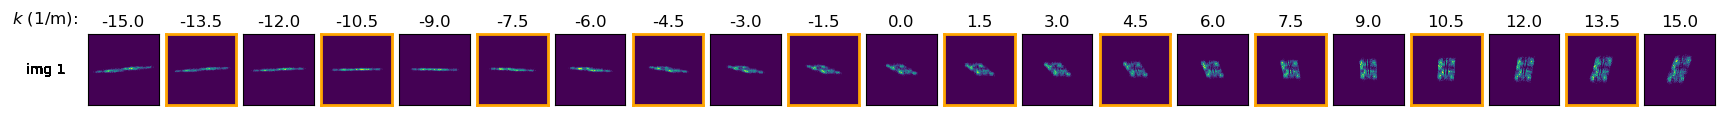

In [6]:
# plot generated datasets
fig, ax = plot_scan_data(train_dset, test_dset, bins, bins)
plt.show()

In [7]:
from phase_space_reconstruction.modeling import (
    NNTransform,
    InitialBeam,
    VariationalPhaseSpaceReconstructionModel,
    ImageDataset,
    PhaseSpaceReconstructionModel3D,
    ImageDataset3D, SextPhaseSpaceReconstructionModel
)
from phase_space_reconstruction.losses import normalize_images
from models import IndependentVariationalNN
import torch
from torch.utils.data import DataLoader



"""
Trains beam model by scanning an arbitrary lattice.
Note: as of now, the quadrupole that is scanned should
be the first element of the lattice.

Parameters
----------
train_data: ImageDataset
    training data

lattice: bmadx TorchLattice
    diagnostics lattice. First element is the scanned quad.

screen: ImageDiagnostic
    screen diagnostics

Returns
-------
predicted_beam: bmadx Beam
    reconstructed beam

"""

# Device selection:
DEVICE = torch.device("cuda")
print(f'Using device: {DEVICE}')

ks = train_dset.k.to(DEVICE)
imgs = train_dset.images.to(DEVICE)

train_dset_device = ImageDataset(ks, imgs)
train_dataloader = DataLoader(
    train_dset_device,
    batch_size=1,
    shuffle=True
    )

# create phase space reconstruction model
nn_transformer = IndependentVariationalNN(6, 5, output_scale=1e-2)
nn_beam = InitialBeam(
    nn_transformer,
    torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6)),
    10000,
    p0c=torch.tensor(p0c),
)
model = VariationalPhaseSpaceReconstructionModel(
    lattice.copy(),
    screen,
    nn_beam
)

Using device: cuda


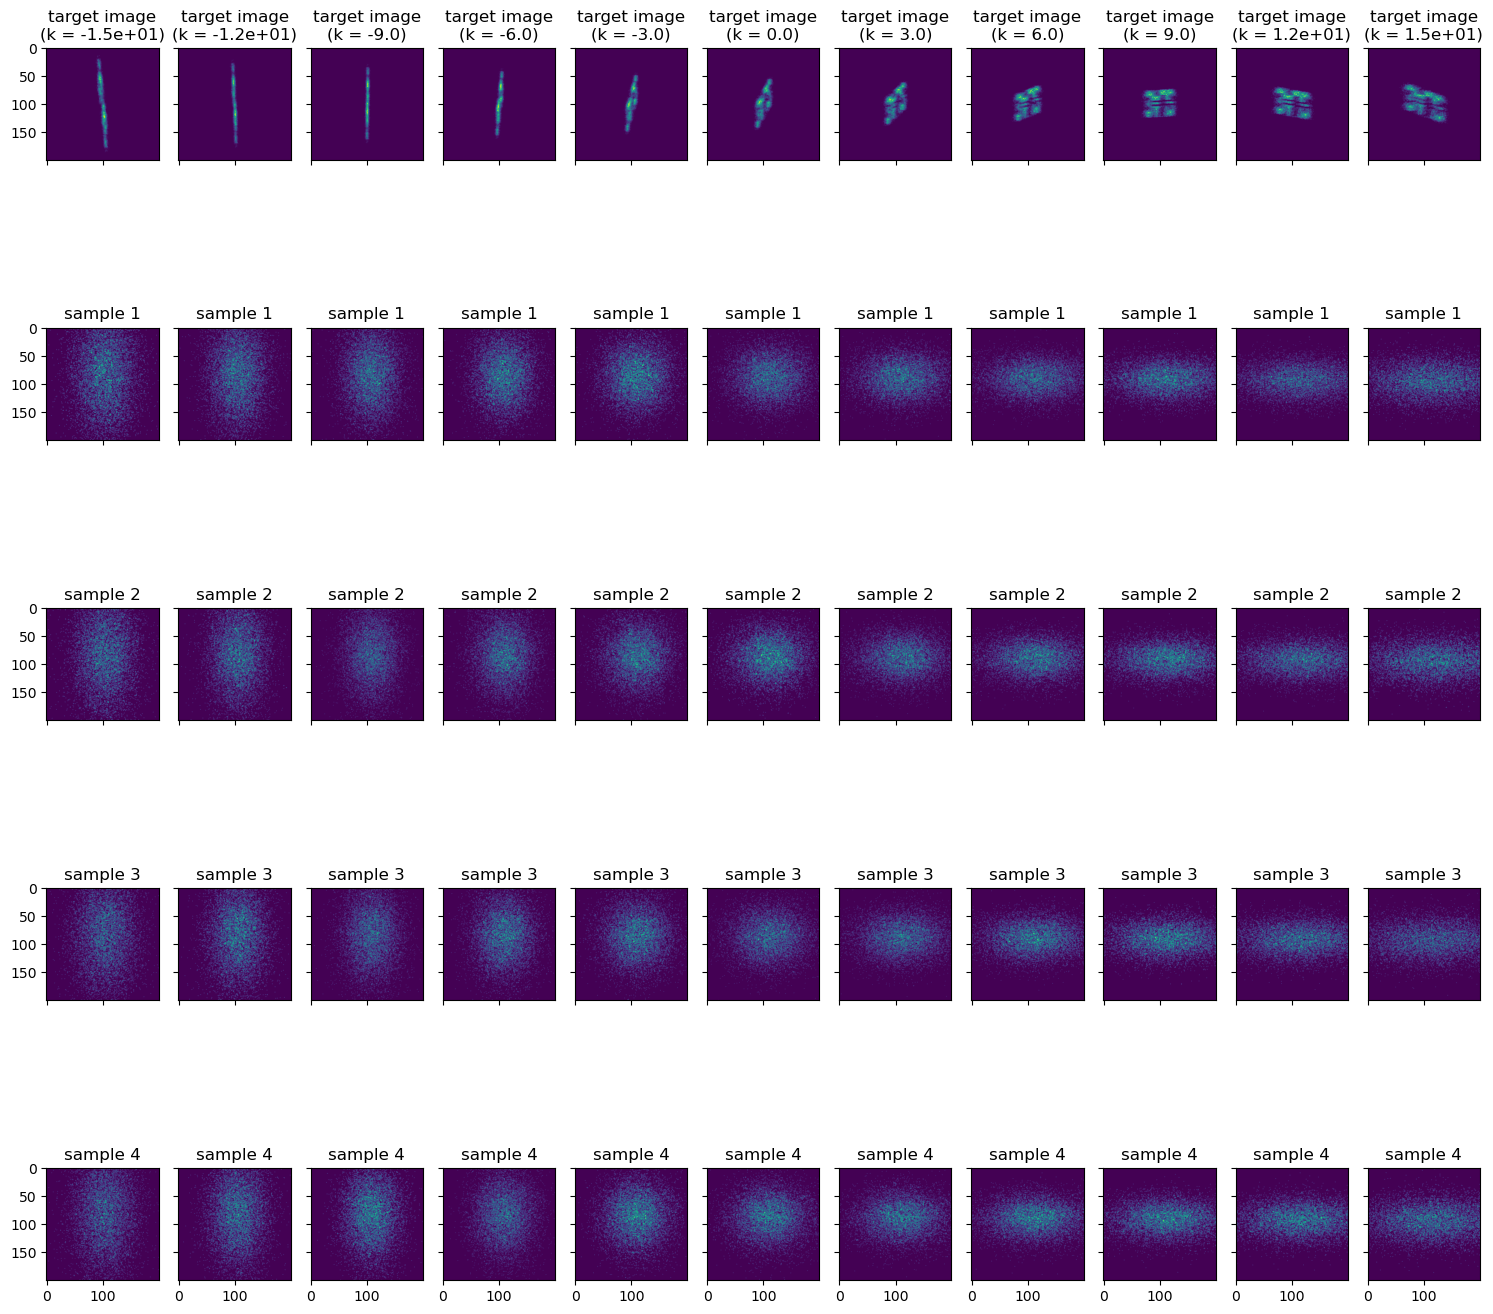

In [8]:
# predict images
output = model(ks.cpu(), 0)

# calculate image loss
target_images = normalize_images(imgs).cpu()
pred_images = normalize_images(output).detach()

fig,ax = plt.subplots(5,len(target_images),sharey="all",sharex="all",figsize=(15,15))
for i in range(len(target_images)):
    ax[0,i].set_title(f"target image\n(k = {float(ks[i]):.2})")
    ax[0,i].imshow(target_images[i,0])

    for j in range(1, len(ax)):
        ax[j,i].imshow(pred_images[i,j])
        ax[j,i].set_title(f"sample {j}")

fig.tight_layout()
fig.savefig(base_fname + "untrained_pred_measurement_comparison.png", dpi=300)

In [9]:
model = model.to(DEVICE)

# train model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_track = []
for i in range(1000):
    k, target_images = ks, imgs
    optimizer.zero_grad()
    output = model(k, 0)

    # calculate image loss
    target_images = normalize_images(target_images)
    pred_images = normalize_images(output)
    #assert target_images.shape == pred_images.shape
    image_loss = torch.mean(torch.abs(target_images - pred_images)) * 1e5

    # calculate uncertainty loss
    prior_loss = (
            model.beam.transformer.std(model.beam.base_beam.data) - 10e-3
    ).pow(2).mean() * 1e4


    loss = image_loss + prior_loss
    loss.backward()
    optimizer.step()

    loss_track += [torch.stack([loss, image_loss, prior_loss])]

    if i % 100 == 0:
        print(i, loss, image_loss, prior_loss)

loss_track = torch.stack(loss_track).detach()

0 tensor(4.1590, device='cuda:0', grad_fn=<AddBackward0>) tensor(4.0492, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.1098, device='cuda:0', grad_fn=<MulBackward0>)


KeyboardInterrupt: 

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(loss_track.cpu(),label=["total loss", "image loss", "prior loss"])
ax2.set_xlabel("iteration")
ax2.legend()
fig2.savefig(base_fname + "loss_curves.png", dpi=300)
model = model.to('cpu')
predicted_beam = model.beam.forward().detach_clone()

In [ ]:
# predict images
output = model(ks.cpu(), 0)

# calculate image loss
target_images = normalize_images(imgs).cpu()
pred_images = normalize_images(output).detach()

fig,ax = plt.subplots(5,len(target_images),sharey="all",sharex="all",figsize=(15,15))
for i in range(len(target_images)):
    ax[0,i].set_title(f"target image\n(k = {float(ks[i]):.2})")
    ax[0,i].imshow(target_images[i,0])

    for j in range(1, len(ax)):
        ax[j,i].imshow(pred_images[i,j])
        ax[j,i].set_title(f"sample {j}")

fig.tight_layout()
fig.savefig(base_fname + "trained_pred_measurement_comparison.png", dpi=300)

In [ ]:
import numpy as np
# plot 2d histogram of x-px phase space
x, px = predicted_beam.x.numpy(), predicted_beam.px.numpy()

histograms = []
hist_range = np.array(((-1e-2,1e-2),(-1e-2,1e-2))) * 1e3
bins=50

gt_H, x_edges, y_edges = np.histogram2d(gt_beam.x*1e3, gt_beam.px*1e3, range=hist_range,
                                            bins=bins)

for i in range(len(x)):
    H, x_edges, y_edges = np.histogram2d(x[i] * 1e3, px[i]*1e3, range=hist_range,
                                         bins=bins)
    xcenters = (x_edges[:-1] + x_edges[1:]) / 2
    ycenters = (y_edges[:-1] + y_edges[1:]) / 2

    histograms += [H]

histograms = np.stack(histograms)
hist_mean = np.mean(histograms, axis=0)
hist_std = np.std(histograms, axis=0)

fig,ax = plt.subplots(1,3, figsize=(12,3),sharey="all",sharex="all")

ax[0].set_title("ground truth")
ax[0].set_xlabel("x (mm)")
ax[0].set_ylabel("px (mrad)")
c =ax[0].pcolor(xcenters, ycenters, gt_H.T)
fig.colorbar(c)

ax[1].set_title("mean prediction")
ax[1].set_xlabel("x (mm)")
c =ax[1].pcolor(xcenters, ycenters, hist_mean.T)
fig.colorbar(c)

ax[2].set_title("std prediction")
ax[2].set_xlabel("x (mm)")
c = ax[2].pcolor(xcenters, ycenters, hist_std.T)
fig.colorbar(c)
fig.savefig(base_fname + "phase_space_pred.png", dpi=300)

In [ ]:
fig, ax = plt.subplots()
for i in range(len(x)):
    ax.plot(x[i], px[i],f".C{i}",ms=1, alpha=0.25)


In [ ]:
model.beam.transformer.std(model.beam.base_beam.data)

In [ ]:
model.beam.transformer.mean(model.beam.base_beam.data)
